# Prepare audio data for image recognition

The data is pretty good, but there's a few samples that aren't exactly 1 second long and some samples that are either truncated or don't contain very much of the word.

The code in the notebook attempts to filter out the broken audio so that we are only using good audio.

We then generate spectrograms of each word.

## Download data set
Download from: https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz - approx 2.3 GB

And then run
```
tar -xzf data_speech_commands_v0.02.tar.gz -C speech_data
```

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm

In [2]:
SPEECH_DATA='speech_data'

In [3]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES/4

In [4]:
# list of folders we want to process in the speech_data folder
from tensorflow.python.ops import gen_audio_ops as audio_ops
words = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
    '_silence'
]

In [5]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/'+word+'/*.wav')

# get the location of the voice
def get_voice_position(audio, noise_floor):
    return tfio.experimental.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()


def is_valid_file(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(audio)
    # is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [14]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(audio)
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True)
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    # remove the first 1 index
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram


In [7]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        print(f'{file_path} is too short')
        return None
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(audio)
    # randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # add some random background noise
    background_volume = np.random.uniform(0, 0.3)
    # get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(background)
    # mix the audio with the scaled background
    audio = audio + background_volume * background
    # get the spectrogram
    return get_spectrogram(audio)

In [8]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [39]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label, file_name) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, repeat=1):
    # the index of the word word we are processing
    label = words.index(word)
    # get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))
    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the words and all the files
for word in tqdm(words, desc="Processing words"):
    if '_' not in word:
        # add more examples of marvin to balance our training set
        repeat = 35 if word == 'marvin' else 1
        process_word(word, repeat=5 * repeat)
    
print(len(train), len(test), len(validate))


564590 71005 70400


In [40]:
# process the background noise files
def process_background(file_name):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32) / 32768.0
    num_sections = len(audio) // 16000
    samples = []
    for section_index in tqdm(range(num_sections), desc=file_name, leave=False):
        section_start = section_index * 16000
        section_end = section_start + 16000
        section = audio[section_start:section_end]
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, len(words), file_name+","+str(section_index)))
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE*len(samples))
    validation_size=int(VALIDATION_SIZE*len(samples))
    test_size=int(TEST_SIZE*len(samples))
    
    train.extend(samples[:train_size])

    validate.extend(samples[train_size:train_size+validation_size])

    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name)

In [41]:
samples = []

for i in tqdm(range(3000), desc="Silence"):
    spectogram = get_spectrogram(np.random.normal(loc=0.0, scale=1.0, size=(16000,1)))
    samples.append((spectogram, len(words)+1, "silence"))

np.random.shuffle(samples)
       
train_size=int(TRAIN_SIZE*len(samples))
validation_size=int(VALIDATION_SIZE*len(samples))
test_size=int(TEST_SIZE*len(samples))

train.extend(samples[:train_size])

validate.extend(samples[train_size:train_size+validation_size])

test.extend(samples[train_size+validation_size:])



In [42]:
print(len(train), len(test), len(validate))

568663 71521 70907


In [43]:
# randomise the training samples
# tf.random.set_seed(567436)
# train = tf.random.shuffle(
#     train, seed=567436
# ).numpy()
np.random.shuffle(train)

In [44]:
X_train, Y_train, FileName_train = zip(*train)
X_validate, Y_validate, FileName_validate = zip(*validate)
X_test, Y_test, FileName_test = zip(*test)


print(len(train), len(X_train), len(Y_train), len(FileName_train))
print(len(validate), len(X_validate), len(Y_validate), len(FileName_validate))
print(len(test), len(X_test), len(Y_test), len(FileName_test))
FileName_train[:10]

568663 568663 568663 568663
70907 70907 70907 70907
71521 71521 71521 71521


(b'speech_data/seven/4845bb10_nohash_0.wav',
 b'speech_data/marvin/d0f7bef5_nohash_0.wav',
 b'speech_data/seven/611d2b50_nohash_0.wav',
 b'speech_data/marvin/821b64cc_nohash_0.wav',
 b'speech_data/marvin/1fd85ee4_nohash_0.wav',
 b'speech_data/marvin/af8b2f2c_nohash_1.wav',
 b'speech_data/no/69086eb0_nohash_0.wav',
 b'speech_data/house/4620dc14_nohash_0.wav',
 b'speech_data/marvin/88e85150_nohash_1.wav',
 b'speech_data/marvin/b843de62_nohash_0.wav')

In [45]:
# save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train, FileNames=FileName_train)
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate, FileNames=FileName_validate)
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test, FileNames=FileName_test)

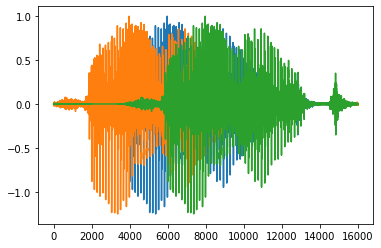

In [31]:
import matplotlib.pyplot as plt

audio_tensor = tfio.audio.AudioIOTensor(SPEECH_DATA+'/forward/0a2b400e_nohash_0.wav')
audio = tf.cast(audio_tensor[:], tf.float32)
# normaliste the audio
audio = audio - np.mean(audio)
audio = audio / np.max(audio)
# randomly reposition the audio in the sample
voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
end_gap=len(audio) - voice_end
random_offset = np.random.uniform(0, voice_start+end_gap)
audio = np.roll(audio,-random_offset+end_gap)
plt.figure()
plt.plot(np.roll(audio[:],0))
plt.plot(np.roll(audio[:], -2000))
plt.plot(np.roll(audio[:], 2000))

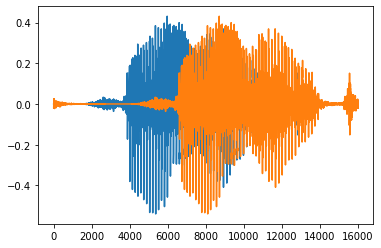

In [72]:
voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
end_gap=len(audio) - voice_end
random_offset = np.random.uniform(0, voice_start+end_gap)
audio2 = np.roll(audio,-random_offset+end_gap)
plt.figure()
plt.plot(audio)
plt.plot(audio2)

0.10955365294341934


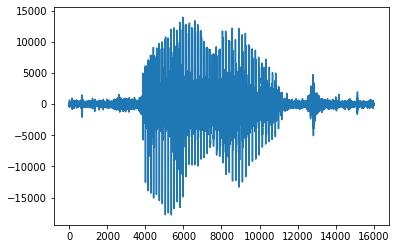

In [38]:
import matplotlib.pyplot as plt

audio_tensor = tfio.audio.AudioIOTensor(SPEECH_DATA+'/forward/0a2b400e_nohash_0.wav')
audio = tf.cast(audio_tensor[:], tf.float32)
plt.figure()
# plt.plot(audio)

background_files = get_files('_background_noise_')
background_file = np.random.choice(background_files)
background_tensor = tfio.audio.AudioIOTensor(background_file)
background_start = np.random.randint(0, len(background_tensor) - 16000)
background_volume = np.random.uniform(0, 0.2)
print(background_volume)
audio2 = audio + background_volume * tf.cast(background_tensor[background_start:background_start+16000], tf.float32)
plt.plot(audio2)

(16000, 1) (16000, 1)


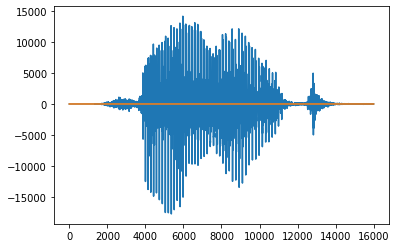

In [22]:
noise = np.random.normal(0, np.random.uniform(0.001, 0.05), (len(audio),1))
noise.shape
plt.figure()
noisy_audio = audio+noise
plt.plot(noisy_audio)
print(audio.shape, noisy_audio.shape)
plt.plot(noise)

In [138]:
word = 'up'
bias = 35 if word == 'marvin' else 1
file_names = tf.repeat(get_files(word), bias)
len(file_names)

3723

In [7]:
get_files('_background_noise_')

['speech_data/_background_noise_/pink_noise.wav',
 'speech_data/_background_noise_/white_noise.wav',
 'speech_data/_background_noise_/background.wav',
 'speech_data/_background_noise_/background2.wav',
 'speech_data/_background_noise_/dude_miaowing.wav',
 'speech_data/_background_noise_/doing_the_dishes.wav',
 'speech_data/_background_noise_/exercise_bike.wav',
 'speech_data/_background_noise_/running_tap.wav']

In [56]:
tf.random.set_seed(123456)
a = tf.random.shuffle(
    [1,2,3,4,5,6], seed=567436
).numpy()
tf.random.set_seed(123456)
b = tf.random.shuffle(
    [1,2,3,4,5,6], seed=567436
).numpy()
a,b

(array([6, 4, 2, 1, 5, 3], dtype=int32),
 array([6, 4, 2, 1, 5, 3], dtype=int32))

In [55]:
a = tf.random.shuffle(
    [1,2,3,4,5,6], seed=567436
).numpy()
b = tf.random.shuffle(
    [1,2,3,4,5,6], seed=567436
).numpy()
a,b

(array([3, 4, 5, 1, 2, 6], dtype=int32),
 array([2, 1, 3, 6, 5, 4], dtype=int32))

(array([ 2089.,  1083.,   980.,  1172.,  2424.,  1862.,  2202.,   993.,
         1044.,  1868.,  1796.,  1192.,  1241.,  1016.,  2243., 48440.,
         2574.,  2050.,  1597.,  2032.,  2027.,  2104.,  2602.,  1328.,
         2530.,  2212.,  1875.,   943.,  1738.,  1052.,  1101.,  1188.,
         2482.,  2817.,     0.,     0.,  3297.]),
 array([ 0.        ,  1.02702703,  2.05405405,  3.08108108,  4.10810811,
         5.13513514,  6.16216216,  7.18918919,  8.21621622,  9.24324324,
        10.27027027, 11.2972973 , 12.32432432, 13.35135135, 14.37837838,
        15.40540541, 16.43243243, 17.45945946, 18.48648649, 19.51351351,
        20.54054054, 21.56756757, 22.59459459, 23.62162162, 24.64864865,
        25.67567568, 26.7027027 , 27.72972973, 28.75675676, 29.78378378,
        30.81081081, 31.83783784, 32.86486486, 33.89189189, 34.91891892,
        35.94594595, 36.97297297, 38.        ]),
 <BarContainer object of 37 artists>)

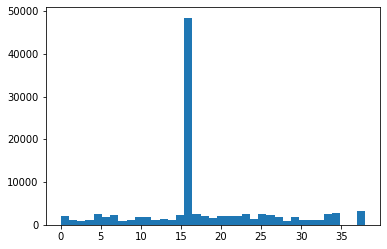

In [193]:
import matplotlib.pyplot as plt
plt.hist(Y_train, bins=len(words))

In [194]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

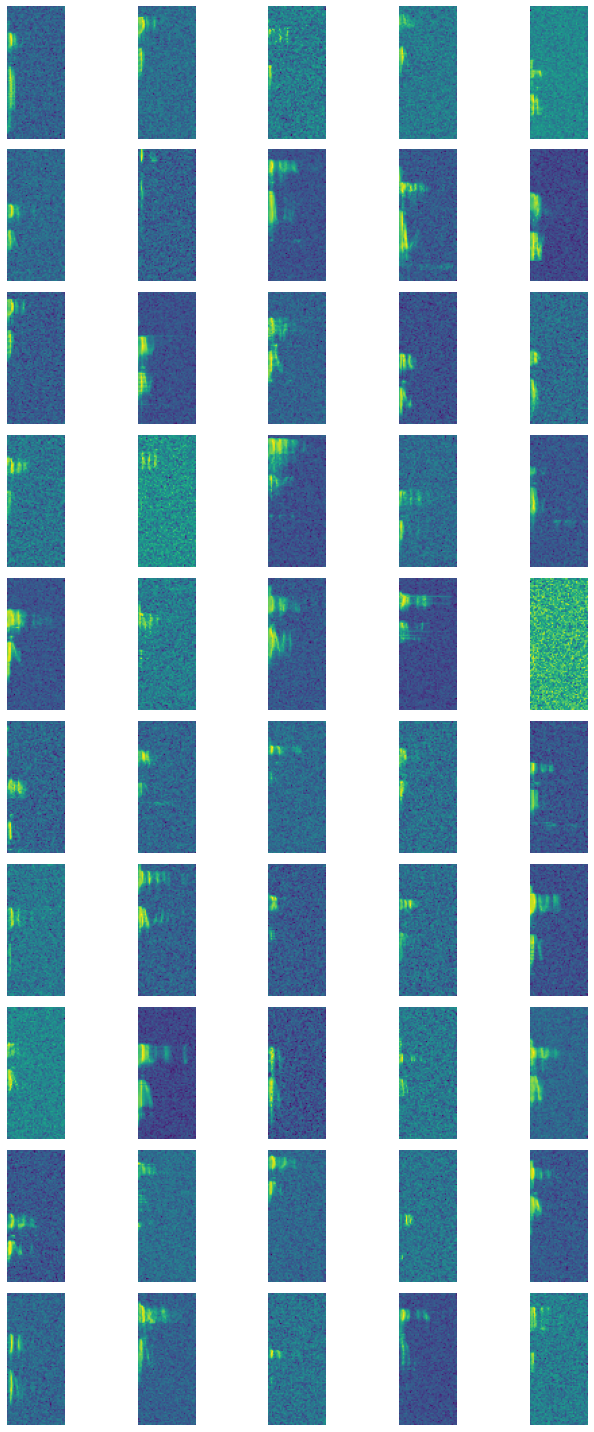

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[b'speech_data/backward/42f81601_nohash_3.wav'
 b'speech_data/backward/95fd5a0f_nohash_5.wav'
 b'speech_data/backward/f30285c8_nohash_4.wav'
 b'speech_data/backward/b8874962_nohash_1.wav'
 b'speech_data/backward/25e95412_nohash_2.wav'
 b'speech_data/backward/ec989d6d_nohash_0.wav'
 b'speech_data/backward/63f7a489_nohash_3.wav'
 b'speech_data/backward/ce0cb033_nohash_2.wav'
 b'speech_data/backward/195c120a_nohash_1.wav'
 b'speech_data/backward/cc4f9250_nohash_0.wav'
 b'speech_data/backward/95fd5a0f_nohash_2.wav'
 b'speech_data/backward/3b195250_nohash_0.wav'
 b'speech_data/backward/472b8045_nohash_3.wav'
 b'speech_data/backward/1e9e6bdd_nohash_4.wav'
 b'speech_data/backward/fd5ccd39_nohash_3.wav'
 b'speech_data/backward/d4dddb92_nohash_0.wav'
 b'speech_data/backward/0d6d7360_nohash_2.wav'
 b'speech_data/backward/7d6b4b10_nohash_1.wav'
 b'speech_data/backward/f30285c8_nohash_3.wav'
 b's

In [205]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(10, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (IMG_WIDTH, IMG_HEIGHT)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    
word_index = words.index("backward")

X_marvins = np.array(X_train)[np.array(Y_train) == word_index]
Y_marvins = np.array(Y_train)[np.array(Y_train) == word_index]
FileName_marvins = np.array(FileName_train)[np.array(Y_train) == word_index]
plot_images2(X_marvins[:50], IMG_WIDTH, IMG_HEIGHT)
print(Y_marvins[:50])
print(FileName_marvins[:50])

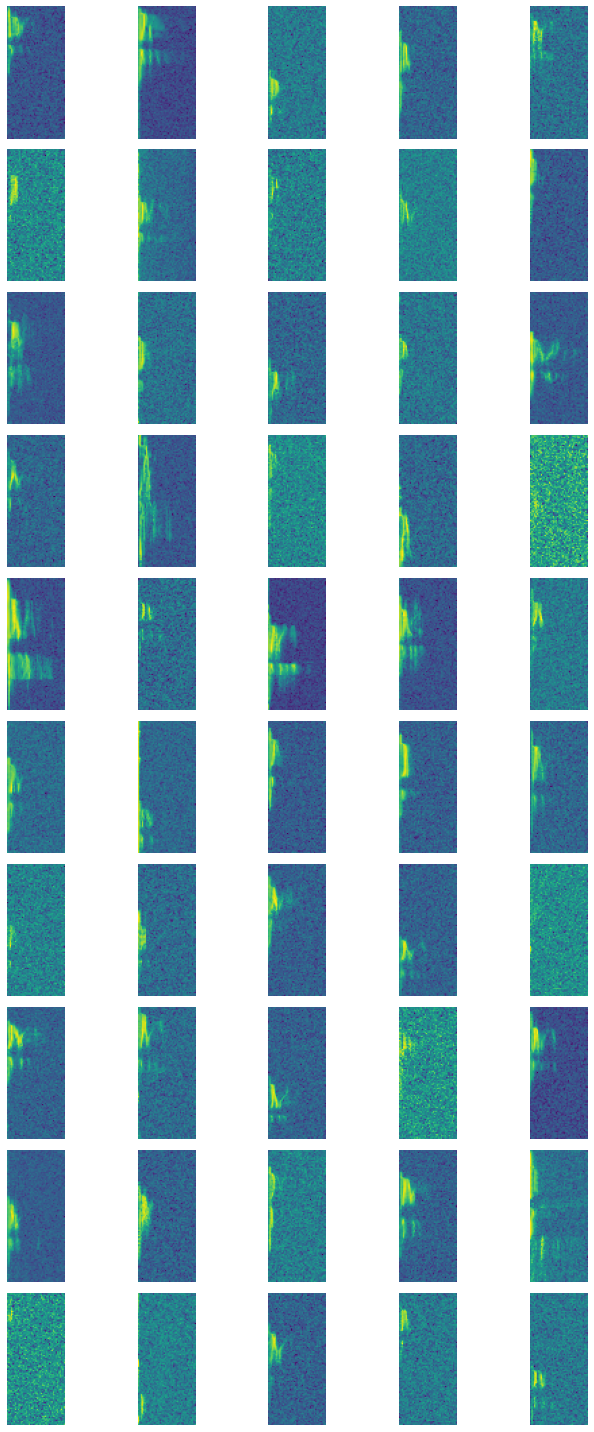

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16]
[b'speech_data/marvin/840c366d_nohash_0.wav'
 b'speech_data/marvin/6823565f_nohash_0.wav'
 b'speech_data/marvin/b4ea0d9a_nohash_1.wav'
 b'speech_data/marvin/0a9f9af7_nohash_2.wav'
 b'speech_data/marvin/84d1e469_nohash_0.wav'
 b'speech_data/marvin/1b4c9b89_nohash_0.wav'
 b'speech_data/marvin/2dce72b3_nohash_0.wav'
 b'speech_data/marvin/66774579_nohash_1.wav'
 b'speech_data/marvin/b843de62_nohash_1.wav'
 b'speech_data/marvin/fb7eb481_nohash_0.wav'
 b'speech_data/marvin/ae82c78c_nohash_0.wav'
 b'speech_data/marvin/a8ee11c7_nohash_1.wav'
 b'speech_data/marvin/1f3e4139_nohash_0.wav'
 b'speech_data/marvin/95ba4996_nohash_0.wav'
 b'speech_data/marvin/f30285c8_nohash_0.wav'
 b'speech_data/marvin/8f4c551f_nohash_0.wav'
 b'speech_data/marvin/173e6bbf_nohash_1.wav'
 b'speech_data/marvin/b93528e3_nohash_1.wav'
 b'speech_data/marvin/ceef6d96_nohas

In [206]:
word_index = words.index("marvin")

X_marvins = np.array(X_train)[np.array(Y_train) == word_index]
Y_marvins = np.array(Y_train)[np.array(Y_train) == word_index]
FileName_marvins = np.array(FileName_train)[np.array(Y_train) == word_index]
plot_images2(X_marvins[:50], IMG_WIDTH, IMG_HEIGHT)
print(Y_marvins[:50])
print(FileName_marvins[:50])

In [6]:
def plot_audio(file_names):
    fig, axes = plt.subplots(10, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(file_names, axes):
        audio_tensor = tfio.audio.AudioIOTensor(file_names)
        audio = tf.cast(audio_tensor[:], tf.float32) / 32768.0
        ax.plot(audio)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    
word_index = words.index("backward")

X_marvins = np.array(X_train)[np.array(Y_train) == word_index]
Y_marvins = np.array(Y_train)[np.array(Y_train) == word_index]
FileName_marvins = np.array(FileName_train)[np.array(Y_train) == word_index]
plot_audio(FileName_marvins[:50])

NameError: name 'X_train' is not defined

In [ ]:
import pyaudio as audio
import struct

FORMAT = audio.paFloat32
RATE = 16000
CHANNELS = 1
NOFFRAMES = 8000
p = pyaudio.PyAudio()
print('running')

# stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,input=True,frames_per_buffer=FRAMESIZE)
# data = stream.read(NOFFRAMES*FRAMESIZE)
# decoded = np.frombuffer(data, 'Float32');


def callback(input_data, frame_count, time_info, flags):
    print("Got audio " + frame_cout)
    return input_data, pyaudio.paContinue

stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    stream_callback=callback,
                    frames_per_buffer=NOFFRAMES)

# stream.stop_stream()
# stream.close()
# p.terminate()
# print('done')
# plt.plot(decoded)
# plt.show()

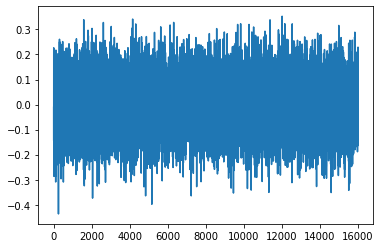

In [49]:
plt.plot(np.random.normal(loc=0.0, scale=0.1, size=(16000,1)))
plt.show()

In [41]:
spec = np.genfromtxt("test_c_code/build/spectrogram.txt",delimiter=",")
print(spec.shape)

(98, 43)


In [12]:
import matplotlib.pyplot as plt

plt.imshow(spec)

NameError: name 'spec' is not defined

(99, 22, 1)


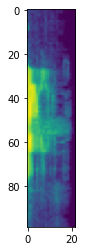

In [15]:
# load the audio file
audio_tensor = tfio.audio.AudioIOTensor('firmware/pre-processing-test/data/sample.wav')
# convert the audio to an array of floats and scale it to betweem -1 and 1
audio = tf.cast(audio_tensor[:], tf.float32)
spec2 = get_spectrogram(audio)
print(spec2.shape)
plt.imshow(spec2)

(98, 42)


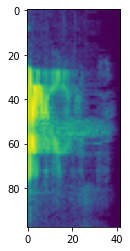

In [46]:
esp_spec = np.genfromtxt("firmware/test_c_code/esp_spectrogram.csv",delimiter=",")
print(esp_spec.shape)
plt.imshow(esp_spec)